In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import replace

from fire_model.ca import FireEnv, FireState, CAFireModel

In [2]:
# ENHANCED PARAMETERS FOR MORE VISIBLE EFFECT
# Note: retardant_k is now set to 20.0 in the env creation cell below
# This cell is just a placeholder - the actual enhancement happens in the env creation
print("Enhanced parameters will be applied in env creation")

Enhanced parameters will be applied in env creation


In [3]:
nx = ny = 120
domain_km = 2.0

fuel = np.ones((nx, ny))
value = np.ones((nx, ny))

wind = np.zeros((nx, ny, 2))
wind[..., 0] = 5.0   # east wind
wind[..., 1] = 0.0

env = FireEnv(
    grid_size=(nx, ny),
    domain_km=domain_km,
    fuel=fuel,
    value=value,
    wind=wind,
    dt_s=3.0,
    burn_time_s0=600.0,
    retardant_half_life_s=3600.0,
    retardant_k=20.0,  # Increased from 10.0 for more visible effect
    drop_w_km=0.04,
    drop_h_km=0.12,
    drop_amount=1.0,
    ros_mps=1.0,
    wind_coeff=0.08,
    diag=True,
)
model = CAFireModel(env, seed=0)

In [4]:
p_init = np.zeros((nx, ny))
cx, cy = nx//2, ny//2
p_init[cx-3:cx+3, cy-3:cy+3] = 1.0

init_state = FireState(
    burning=p_init[None],
    burned=np.zeros((1, nx, ny)),
    burn_remaining_s=np.full((1, nx, ny), env.burn_time_s0),
    retardant=np.zeros((1, nx, ny)),
    t=0,
)

In [5]:
final_baseline = model.simulate_from_firestate(
    init_state,
    T=300.0,
    n_sims=100,
)

affected_baseline = np.clip(
    final_baseline.burning[0] + final_baseline.burned[0], 0, 1
)

baseline_loss = np.sum(affected_baseline * env.value)
print("Baseline loss:", baseline_loss)

No drone_params
Baseline loss: 8222.49


In [6]:
# Debug the heuristic calculation
burning = init_state.burning[0]  # Fixed: use init_state instead of state_h
print("burning shape:", burning.shape)
print("burning dtype:", burning.dtype)
print("burning min/max:", burning.min(), burning.max())
print("burning > 0 count:", np.sum(burning > 0))

coords = np.column_stack(np.where(burning > 0))
print("coords shape:", coords.shape)
print("coords range i:", coords[:, 0].min(), "to", coords[:, 0].max())
print("coords range j:", coords[:, 1].min(), "to", coords[:, 1].max())

w = env.wind.mean(axis=(0,1))
print("wind:", w)
w_hat = w / np.linalg.norm(w)
print("w_hat:", w_hat)

proj = coords @ w_hat
print("proj min/max:", proj.min(), proj.max())
cut = np.quantile(proj, 0.95)
print("cut (95th percentile):", cut)
head_cells = coords[proj >= cut]
print("head_cells shape:", head_cells.shape)
head = head_cells.mean(axis=0)
print("head (mean of head cells):", head)

burning shape: (120, 120)
burning dtype: float64
burning min/max: 0.0 1.0
burning > 0 count: 36
coords shape: (36, 2)
coords range i: 57 to 62
coords range j: 57 to 62
wind: [5. 0.]
w_hat: [1. 0.]
proj min/max: 57.0 62.0
cut (95th percentile): 62.0
head_cells shape: (6, 2)
head (mean of head cells): [62.  59.5]


In [7]:
def downwind_blocking_heuristic(state, n_drops=6, offset_cells=0, spacing_cells=3):
    burning = state.burning[0]
    ij = np.column_stack(np.where(burning > 0))  # (i=row, j=col)

    if ij.size == 0:
        return np.zeros((0, 3), dtype=float)

    cell_size_km = env.domain_km / nx

    # Wind is (x, y). In array indices, x ↔ j (col), y ↔ i (row).
    w = env.wind.mean(axis=(0, 1))
    w_hat = w / (np.linalg.norm(w) + 1e-12)
    perp = np.array([-w_hat[1], w_hat[0]])  # perpendicular in (x,y)

    # Convert burning cell indices (i,j) to (x,y) coordinates for projection:
    xy = np.column_stack([ij[:, 1], ij[:, 0]])  # (x=j, y=i)

    proj = xy @ w_hat
    cut = np.quantile(proj, 0.95)
    head_xy = xy[proj >= cut].mean(axis=0)  # head in (x,y)

    drops = []
    for k in range(n_drops):
        alpha = k - (n_drops - 1) / 2.0

        # Place a line perpendicular to wind, offset downwind by offset_cells
        drop_xy = head_xy + offset_cells * w_hat + alpha * spacing_cells * perp

        # Convert (x,y) back to grid indices (j,i)
        j = int(np.clip(round(drop_xy[0]), 0, nx - 1))
        i = int(np.clip(round(drop_xy[1]), 0, ny - 1))

        # Convert indices to km: x from j, y from i
        x_km = j * cell_size_km
        y_km = i * cell_size_km

        # Orientation: long axis should be perpendicular to wind (i.e., along perp).
        # apply_retardant_cartesian uses phi as the *width-axis* orientation in your usage,
        # but you were setting phi = perp angle. Keep that consistent for now.
        phi = np.arctan2(perp[1], perp[0])

        drops.append((x_km, y_km, phi))

    return np.array(drops, dtype=float)

In [8]:
state_h = replace(init_state, retardant=np.zeros_like(init_state.retardant))

drops = downwind_blocking_heuristic(state_h)

model.apply_retardant_cartesian(
    state_h,
    drops,
    drop_w_km=env.drop_w_km,
    drop_h_km=env.drop_h_km,
    amount=1.0,
    avoid_burning=False,
)

print("Total retardant before sim:", state_h.retardant.sum())
print("Retardant shape:", state_h.retardant.shape)
print("Retardant max:", state_h.retardant.max())
print("Retardant k:", env.retardant_k)
print("Expected attenuation at max retardant:", np.exp(-env.retardant_k * state_h.retardant.max()))
print("Cells with retardant > 0:", np.sum(state_h.retardant[0] > 0))

Applying retardant drop: D=[[1.03333333 0.86666667 1.57079633]
 [1.03333333 0.91666667 1.57079633]
 [1.03333333 0.96666667 1.57079633]
 [1.03333333 1.01666667 1.57079633]
 [1.03333333 1.06666667 1.57079633]
 [1.03333333 1.11666667 1.57079633]], amount=1.0, drop_w_km=0.04, drop_h_km=0.12
Total retardant before sim: 126.0
Retardant shape: (1, 120, 120)
Retardant max: 1.0
Retardant k: 20.0
Expected attenuation at max retardant: 2.061153622438558e-09
Cells with retardant > 0: 126


In [9]:
# Check state_h before simulation
print("=== BEFORE SIMULATION ===")
print("state_h.retardant.sum():", state_h.retardant.sum())
print("state_h.retardant.shape:", state_h.retardant.shape)
print("state_h.burning type:", type(state_h.burning))
print("state_h.burning dtype:", state_h.burning.dtype if hasattr(state_h.burning, 'dtype') else 'N/A')
print("state_h.burning shape:", state_h.burning.shape)

final_h = model.simulate_from_firestate(
    state_h,
    T=300.0,
    n_sims=100,
)

print("\n=== AFTER SIMULATION ===")
print("Total retardant after sim:", final_h.retardant.sum())
print("Retardant shape:", final_h.retardant.shape)
print("Retardant max:", final_h.retardant.max())

affected_h = np.clip(
    final_h.burning[0] + final_h.burned[0], 0, 1
)

heuristic_loss = np.sum(affected_h * env.value)
print("Heuristic loss:", heuristic_loss)

# After sim:
fire_final = affected_h > 0
retardant_placed = state_h.retardant[0] > 0

print("OVERLAP with final fire:", np.sum(fire_final & retardant_placed))

=== BEFORE SIMULATION ===
state_h.retardant.sum(): 126.0
state_h.retardant.shape: (1, 120, 120)
state_h.burning type: <class 'numpy.ndarray'>
state_h.burning dtype: float64
state_h.burning shape: (1, 120, 120)
No drone_params

=== AFTER SIMULATION ===
Total retardant after sim: 118.92816339789366
Retardant shape: (1, 120, 120)
Retardant max: 0.9438743126816956
Heuristic loss: 6868.869999999999
OVERLAP with final fire: 24


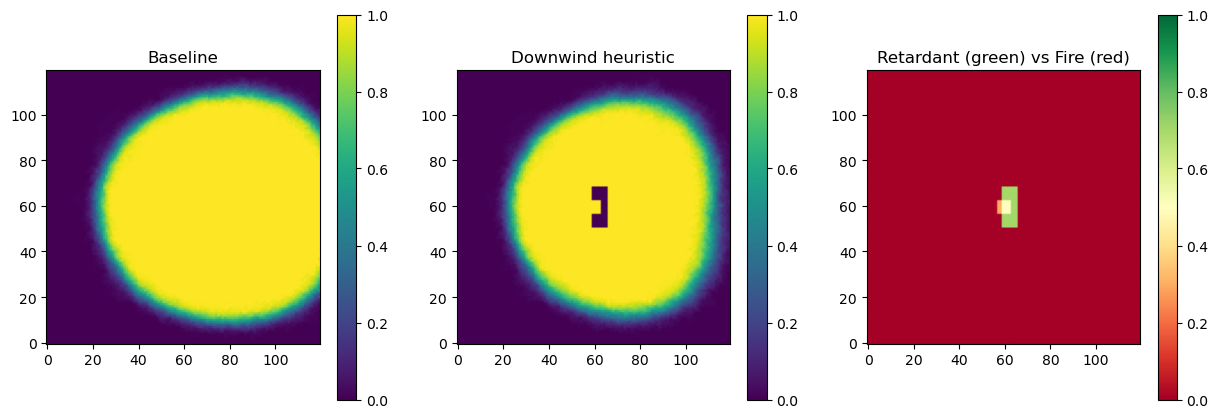

Retardant coverage: 126 cells
Fire at start coverage: 36 cells
Overlap: 24 cells
Retardant locations (first 10): [[59 51]
 [59 52]
 [59 53]
 [59 54]
 [59 55]
 [59 56]
 [59 57]
 [59 58]
 [59 59]
 [59 60]]
Retardant i range: 59 to 65
Retardant j range: 51 to 68

Fire final coverage: 9608 cells
Fire final i range: 12 to 119
Fire final j range: 3 to 118
Retardant overlap with final fire: 24 cells
Percentage of retardant cells that fire reached: 19.047619047619047 %


In [10]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(affected_baseline.T, origin="lower")
plt.title("Baseline")
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(affected_h.T, origin="lower")
plt.title("Downwind heuristic")
plt.colorbar()

plt.subplot(1,3,3)
# Show where retardant was placed - fix visualization
retardant_placed = state_h.retardant[0] > 0
fire_at_start = state_h.burning[0] > 0
combined = np.zeros_like(retardant_placed, dtype=float)
# Set fire first (red = 0.3)
combined[fire_at_start] = 0.3
# Then set retardant (green = 0.7), which will show even if overlapping
combined[retardant_placed] = 0.7
# If both, show as yellow (0.5)
combined[fire_at_start & retardant_placed] = 0.5
plt.imshow(combined.T, origin="lower", cmap='RdYlGn', vmin=0, vmax=1)
plt.title("Retardant (green) vs Fire (red)")
plt.colorbar()
plt.show()

print("Retardant coverage:", np.sum(retardant_placed), "cells")
print("Fire at start coverage:", np.sum(fire_at_start), "cells")
print("Overlap:", np.sum(fire_at_start & retardant_placed), "cells")
retardant_coords = np.column_stack(np.where(retardant_placed))
if len(retardant_coords) > 0:
    print("Retardant locations (first 10):", retardant_coords[:10])
    print("Retardant i range:", retardant_coords[:, 0].min(), "to", retardant_coords[:, 0].max())
    print("Retardant j range:", retardant_coords[:, 1].min(), "to", retardant_coords[:, 1].max())

# Check where fire actually spread
fire_final = affected_h > 0
print("\nFire final coverage:", np.sum(fire_final), "cells")
fire_final_coords = np.column_stack(np.where(fire_final))
if len(fire_final_coords) > 0:
    print("Fire final i range:", fire_final_coords[:, 0].min(), "to", fire_final_coords[:, 0].max())
    print("Fire final j range:", fire_final_coords[:, 1].min(), "to", fire_final_coords[:, 1].max())
    
# Check if retardant overlaps with final fire
if len(retardant_coords) > 0:
    overlap_final = np.sum(fire_final & retardant_placed)
    print("Retardant overlap with final fire:", overlap_final, "cells")
    print("Percentage of retardant cells that fire reached:", overlap_final / np.sum(retardant_placed) * 100 if np.sum(retardant_placed) > 0 else 0, "%")